# Dependencies, imports

In [1]:
import sys
COLAB = 'google.colab' in sys.modules

COLAB

True

In [2]:
if COLAB:
    # Dependencies
    %pip install pyquadkey2
    %pip install osm2geojson
    %pip install geopandas shapely rasterio matplotlib

In [3]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import requests

from itertools import product
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis

import requests
import json

from pyquadkey2 import quadkey
import osm2geojson

import random
from matplotlib.image import imread

import rasterio
from rasterio.features import rasterize
from shapely.geometry import box

import geopandas as gpd
from geopandas import GeoDataFrame

In [5]:
data_folder = 'data'

In [6]:
def show_images_side_by_side(images):
  cols = len(images)

  fig = figure()

  for i in range(cols):
    fig.add_subplot(1, cols, i+1)

    if len(images[i].shape) == 2 or (len(images[i].shape) == 3 and images[i].shape[2] == 1):
      imshow(images[i], cmap='Greys_r')
    else:
      imshow(images[i])

    axis('off')

# Define region of interest

In [7]:
# Define region of interest

min_lat = -11.5
min_lon = -69.6
max_lat = -10.9
max_lon = -68.7

In [8]:
zoom_level = 17

# Tiles limits can slightly exceed the region of interest. Extended coordinates
# cover the whole extent of all the tiles within the region of interest
extended_min_lat, extended_min_lon = quadkey.from_geo((min_lat, min_lon), zoom_level).to_geo(anchor=quadkey.TileAnchor.ANCHOR_SW)
extended_max_lat, extended_max_lon = quadkey.from_geo((max_lat, max_lon), zoom_level).to_geo(anchor=quadkey.TileAnchor.ANCHOR_NE)

In [9]:
# Get all tile IDs within the RoI

min_col, min_row = quadkey.from_geo((max_lat, min_lon), zoom_level).to_tile()[0]
max_col, max_row = quadkey.from_geo((min_lat, max_lon), zoom_level).to_tile()[0]

tiles = [i for i in product(range(min_row, max_row+1), range(min_col, max_col+1))]

print(min_col, min_row, max_col, max_row)

40195 69528 40523 69751


# Download map data

In [10]:
# Overpass API allows advanced queries on the OpenStreetMap data

overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = f"""
[out:json];
(
  way({extended_min_lat}, {extended_min_lon}, {extended_max_lat}, {extended_max_lon});
);
out body;
>;
out skel qt;

"""
response = requests.get(overpass_url,
                        params={'data': overpass_query})


In [11]:
data = response.json()

len(data['elements'])

155867

In [12]:
# Convert data in OSM format to GeoJSON
geojson = osm2geojson.json2geojson(data, filter_used_refs=False, log_level='INFO')

In [13]:
# Filter data. Leave only lines (LineString) with 'highway' property.
# This includes roads and strets.
filtered_features = [feat for feat in geojson['features'] if feat['geometry']['type'] == 'LineString' and 'tags' in feat['properties'] and 'highway' in feat['properties']['tags']]

for feat in filtered_features:
  feat['properties'] = {}

geojson['features'] = filtered_features

In [14]:
with open('geojson.json', 'w') as f:
    json.dump(geojson, f)

In [15]:
gdf = gpd.read_file('geojson.json')

geojson_folder = f'{data_folder}/geojson'
os.makedirs(geojson_folder, exist_ok=True)

for tile in tqdm(tiles):
  tile_min_lat, tile_min_lon = quadkey.from_tile((tile[1], tile[0]), zoom_level).to_geo(anchor=quadkey.TileAnchor.ANCHOR_SW)
  tile_max_lat, tile_max_lon = quadkey.from_tile((tile[1], tile[0]), zoom_level).to_geo(anchor=quadkey.TileAnchor.ANCHOR_NE)

  tile_bbox = box(tile_min_lon, tile_min_lat, tile_max_lon, tile_max_lat)

  gdf_tile = gpd.clip(gdf, tile_bbox)

  gdf_tile.to_file(f'{geojson_folder}/geojson_{zoom_level}_{tile[0]}_{tile[1]}.json', driver='GeoJSON')


100%|██████████| 73696/73696 [05:57<00:00, 205.86it/s]


## Rasterize map data

Create images from map data for training

In [17]:
# Load the shapefile
gdf = gpd.read_file('geojson.json')

In [18]:
gdf

,geometry
0,"LINESTRING (-68.74923 -11.00174, -68.74987 -11..."
1,"LINESTRING (-68.71727 -11.03803, -68.71761 -11..."
2,"LINESTRING (-68.78368 -10.9694, -68.78417 -10...."
3,"LINESTRING (-68.75383 -11.02186, -68.75371 -11..."
4,"LINESTRING (-68.79796 -11.13806, -68.7981 -11...."
...,...
4508,"LINESTRING (-68.72258 -11.44742, -68.72257 -11..."
4509,"LINESTRING (-68.7233 -11.44688, -68.72336 -11...."
4510,"LINESTRING (-68.74726 -11.01097, -68.74711 -11..."
4511,"LINESTRING (-68.74782 -11.01229, -68.74785 -11..."


In [19]:
# Add a certain width to geometry lines. This converts the lines into polygons
# with this width. This ensures the lines are wide enough to show in the rasters
buffer_width = 0.00002

gdf_buffered = gdf.buffer(buffer_width)

<ipython-input-19-a860c0d372ba>:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered = gdf.buffer(buffer_width)


In [20]:
raster_width = 256
raster_height = 256

raster_folder = f'{data_folder}/raster'
os.makedirs(raster_folder, exist_ok=True)

map_tiles = []

# We will generate one raster per tile
for tile in tqdm(tiles):
  tile_min_lat, tile_min_lon = quadkey.from_tile((tile[1], tile[0]), zoom_level).to_geo(anchor=quadkey.TileAnchor.ANCHOR_SW)
  tile_max_lat, tile_max_lon = quadkey.from_tile((tile[1], tile[0]), zoom_level).to_geo(anchor=quadkey.TileAnchor.ANCHOR_NE)

  tile_bbox = box(tile_min_lon, tile_min_lat, tile_max_lon, tile_max_lat)

  gdf_tile = gdf_buffered[gdf_buffered.intersects(tile_bbox)]

  # Prepare the geometry transformation. This maps geo-coordinates to the
  # image dimension space (256x256)
  transform = rasterio.transform.from_bounds(west=tile_min_lon,
                                              south=tile_min_lat,
                                              east=tile_max_lon,
                                              north=tile_max_lat,
                                              width=raster_width,
                                              height=raster_height
                                              )

  # Number of rows, columns in the raster
  out_shape = (raster_height, raster_width)

  geometries = [(geom, 255) for geom in gdf_tile.geometry]

  if not geometries:
      continue

  # Rasterize the buffered roads
  raster = rasterize(shapes=geometries,
                      out_shape=out_shape,
                      transform=transform,
                      all_touched=True,
                      fill=0,
                      dtype='uint8'
                      )

  # Store rasters as PNG images
  with rasterio.open(f'{raster_folder}/raster_{zoom_level}_{tile[0]}_{tile[1]}.png', 'w',
                  driver='PNG',
                  height=raster.shape[0],
                  width=raster.shape[1],
                  count=1,
                  dtype=raster.dtype,
                  crs=gdf_tile.crs,
                  transform=transform) as dst:
      dst.write(raster, 1)

  map_tiles.append(tile)

100%|██████████| 73696/73696 [03:35<00:00, 341.82it/s]


# Download image tiles

In [21]:
# We can check this link to verify it's built correctly
print(f"URL of first tile: https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{zoom_level}/{tiles[0][0]}/{tiles[0][1]}")

URL of first tile: https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/17/69528/40195


In [22]:
img_folder = f'{data_folder}/img'

os.makedirs(img_folder, exist_ok=True)

for tile in tqdm(map_tiles):
  row = tile[0]
  column = tile[1]
  url = f"https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{zoom_level}/{row}/{column}"

  data = requests.get(url).content
  f = open(f'{img_folder}/tile_{zoom_level}_{row}_{column}.jpg','wb')

  f.write(data)
  f.close()

100%|██████████| 9256/9256 [15:48<00:00,  9.76it/s]


# Display sample data

In [23]:
img_paths = sorted(
    [
        os.path.join(img_folder, fname)
        for fname in os.listdir(img_folder)
        if fname.endswith(".jpg")
    ]
)
raster_paths = sorted(
    [
        os.path.join(raster_folder, fname)
        for fname in os.listdir(raster_folder)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [24]:
len(img_paths)

9256

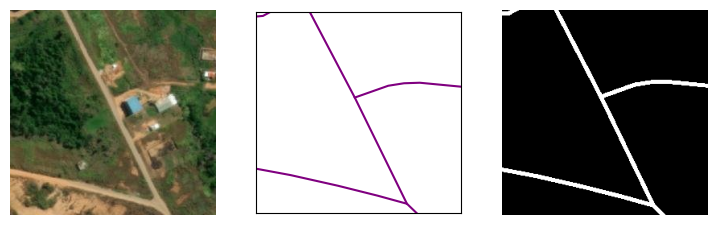

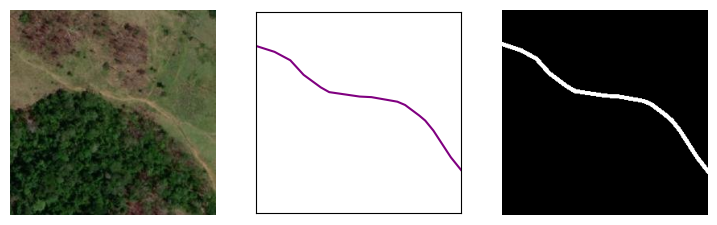

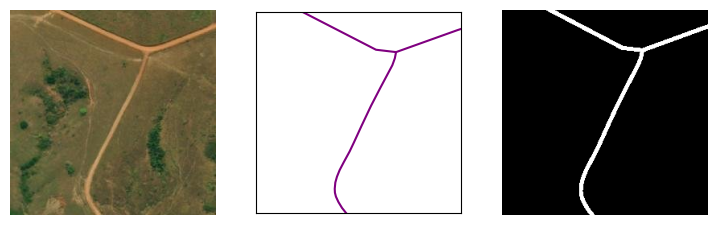

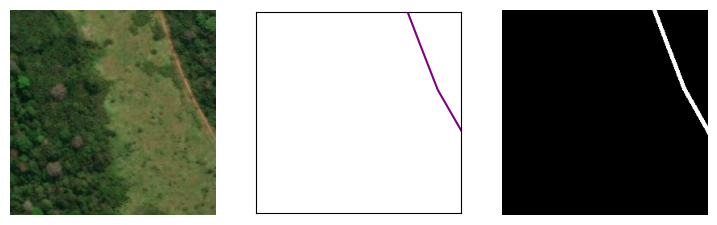

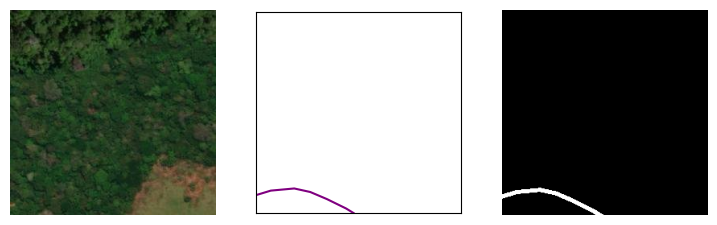

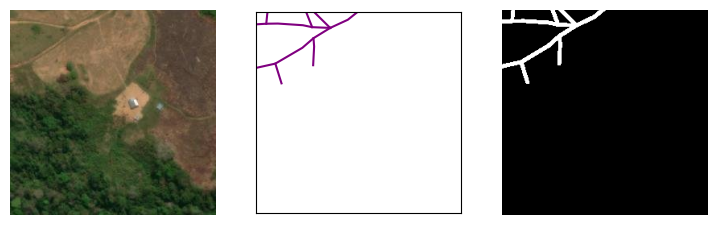

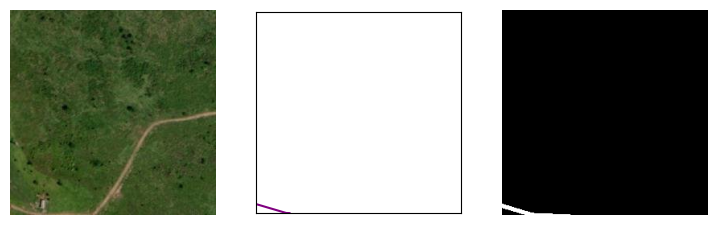

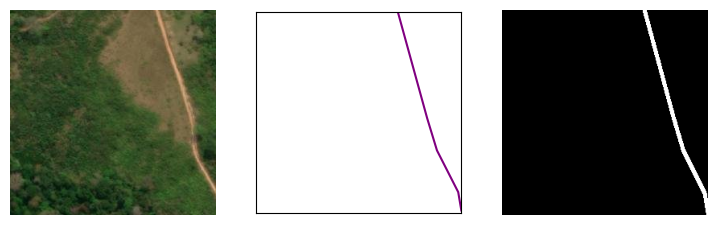

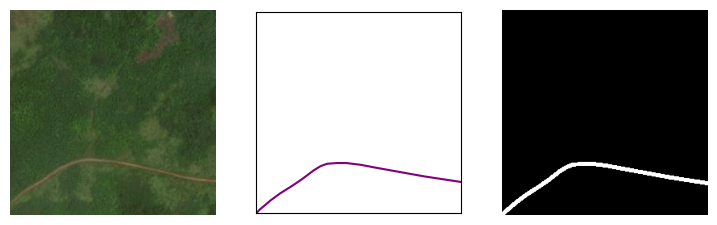

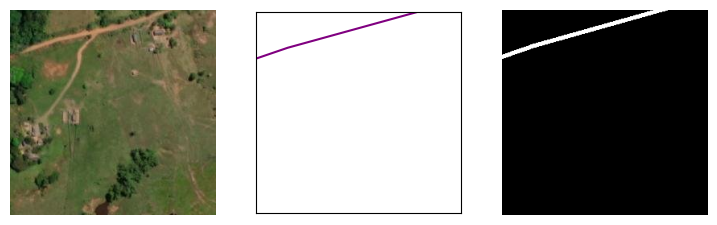

In [25]:
for i in random.sample(range(len(map_tiles)), 10):
  cols = 3

  fig = figure(figsize=(9,3))
  fig.tight_layout()

  # Display satellite image
  ax = fig.add_subplot(1, cols, 1)
  imshow(imread(img_paths[i]))
  ax.axis('off')

  # Display GeoJSON geometry
  tile = map_tiles[i]
  gdf_tile = gpd.read_file(f'{geojson_folder}/geojson_17_{tile[0]}_{tile[1]}.json')

  tile_min_lat, tile_min_lon = quadkey.from_tile((tile[1], tile[0]), zoom_level).to_geo(anchor=quadkey.TileAnchor.ANCHOR_SW)
  tile_max_lat, tile_max_lon = quadkey.from_tile((tile[1], tile[0]), zoom_level).to_geo(anchor=quadkey.TileAnchor.ANCHOR_NE)

  ax = fig.add_subplot(1, cols, 2)
  plt.xlim([tile_min_lon,tile_max_lon])
  plt.ylim([tile_min_lat,tile_max_lat])
  ax.set_aspect('equal')

  plt.xticks([])
  plt.yticks([])

  for geom in gdf_tile.geometry:

    if geom.geom_type == 'LineString':
      x, y = geom.xy
      plt.plot(x, y, color='purple')

    elif geom.geom_type == 'MultiLineString':
        for line in geom.geoms:
            x, y = line.xy
            plt.plot(x, y, color='purple')

  # Display geometry raster
  ax = fig.add_subplot(1, cols, 3)
  imshow(imread(raster_paths[i]), cmap='Greys_r')
  axis('off')

# Zip and upload to Drive

In [26]:
import shutil
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

if COLAB:
    archive_path = f'/content/drive/MyDrive/MBIT/Proyecto/data_{timestamp}'
else:
    archive_path = f'data_{timestamp}'

shutil.make_archive(archive_path, 'zip', root_dir='data')

'/content/drive/MyDrive/MBIT/Proyecto/data_20241003_161203.zip'